# scRNA-seq Analysis of *Parhyale hawaiensis* with Scanpy

Author: Miquel Sendra  
This notebook follows best practices for reproducible single-cell RNA-seq analysis using `scanpy`, starting from STARsolo outputs.

In [1]:
# Imports and settings
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

# Set up paths
DATA_DIR = Path("../../../workspace/scParhyale_data/raw")
METADATA_FILE = Path("../../../workspace/scParhyale_data/metadata.xlsx")
LIBRARIES = ["lib01", "lib02", "lib03", "lib04", "lib05", "lib06"]

## Load Metadata

In [2]:
# Load only relevant columns
metadata_df = pd.read_excel(METADATA_FILE, usecols=["Count", "Sample Name"])

# Exctract Stage and Phenotype from 'Sample Name'
metadata_df["Stage"] = metadata_df["Sample Name"].str.extract(r"\((?:Wild-type|Ablated) (\w+)\)")[0]
metadata_df["Phenotype"] = metadata_df["Sample Name"].str.extract(r"\((Wild-type|Ablated)")[0]

# Replace 'Wild-type' with 'WT' for consistency
metadata_df["Phenotype"] = metadata_df["Phenotype"].replace({"Wild-type": "WT"})


# Parse the 'Sample Name' to extract 'Library ID'
metadata_df["Library ID"] = metadata_df["Count"].apply(lambda x: f"lib0{x}")

metadata_df.index = metadata_df["Library ID"]
metadata_df.index = metadata_df.index.astype(str)
metadata_df

,Count,Sample Name,Stage,Phenotype,Library ID
Library ID,,,,,
lib01,1,Library 1 (Wild-type Early),Early,WT,lib01
lib02,2,Library 2 (Ablated Early),Early,Ablated,lib02
lib03,3,Library 3 (Wild-type Mid),Mid,WT,lib03
lib04,4,Library 4 (Ablated Mid),Mid,Ablated,lib04
lib05,5,Library 5 (Wild-type Late),Late,WT,lib05
lib06,6,Library 6 (Ablated Late),Late,Ablated,lib06


## Load STARsolo matrices and build combined AnnData object

In [3]:
# Load libraries and store AnnData objects
adatas = []
for lib in LIBRARIES:
    ad = sc.read_10x_mtx(DATA_DIR / lib, var_names='gene_symbols', cache=True)
    ad.obs["library_id"] = lib
    ad.obs = ad.obs.merge(metadata_df, left_on="library_id", right_index=True)
    ad.var_names_make_unique()
    adatas.append(ad)

# Concatenate all
adata = anndata.concat(
    adatas,
    label="batch",
    keys=LIBRARIES,
    index_unique="-"
)

adata

AnnData object with n_obs × n_vars = 20172 × 54715
    obs: 'library_id', 'Count', 'Sample Name', 'Stage', 'Phenotype', 'Library ID', 'batch'

## Preprocessing

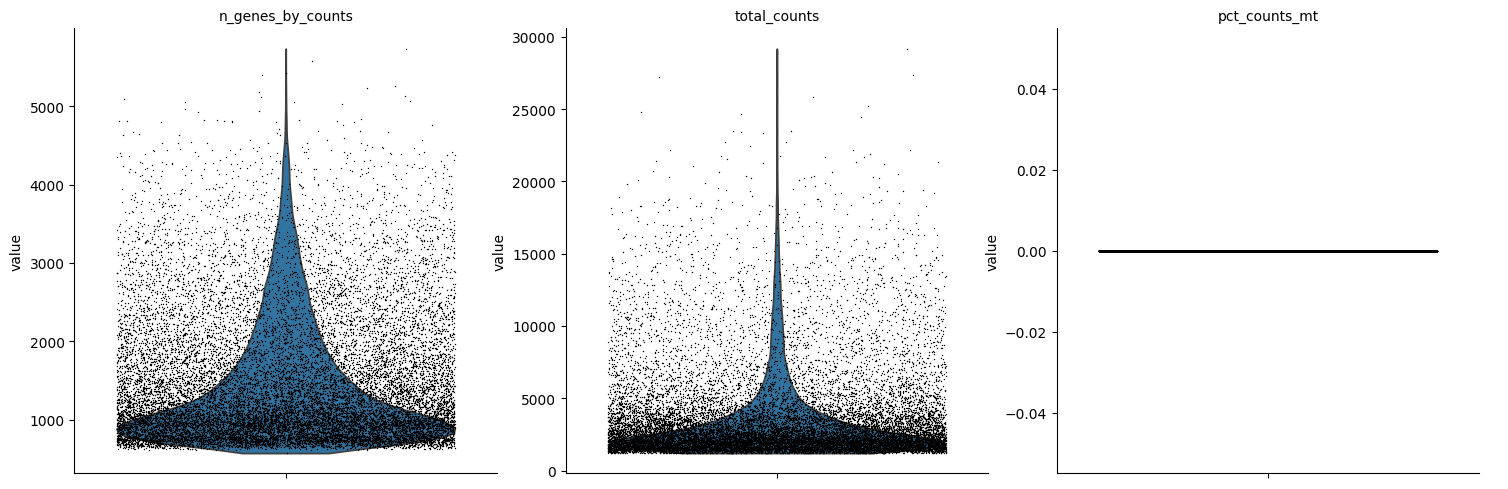

In [4]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
# Calculate QC metrics
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
# Plot QC
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
             jitter=0.4, multi_panel=True)

## Filtering based on QC

In [5]:
# Apply thresholds based on inspection
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]
adata

View of AnnData object with n_obs × n_vars = 20172 × 29320
    obs: 'library_id', 'Count', 'Sample Name', 'Stage', 'Phenotype', 'Library ID', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## Normalization and Log Transformation

In [6]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

/home/msendra/miniforge3/envs/scRNAseq/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Highly Variable Genes

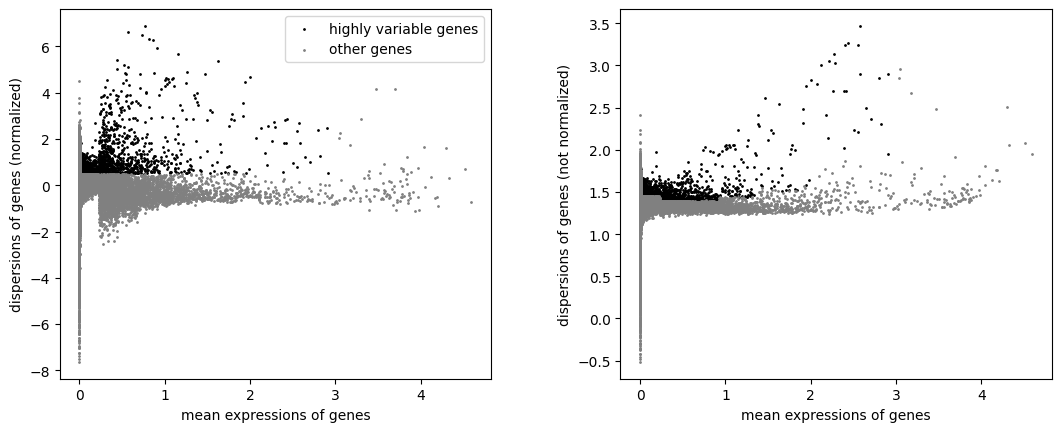

In [7]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]

## PCA, Neighbors, UMAP

/home/msendra/miniforge3/envs/scRNAseq/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/msendra/miniforge3/envs/scRNAseq/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


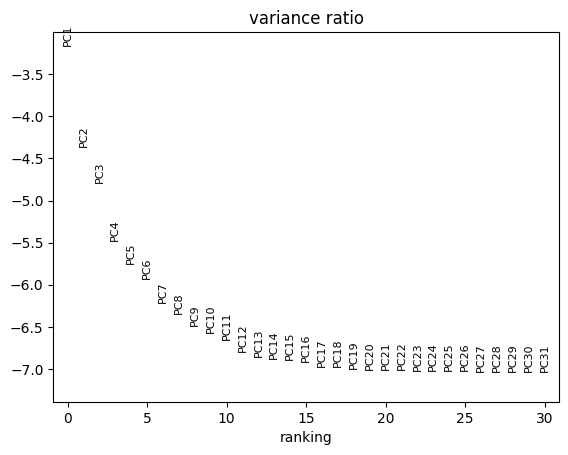

/home/msendra/miniforge3/envs/scRNAseq/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


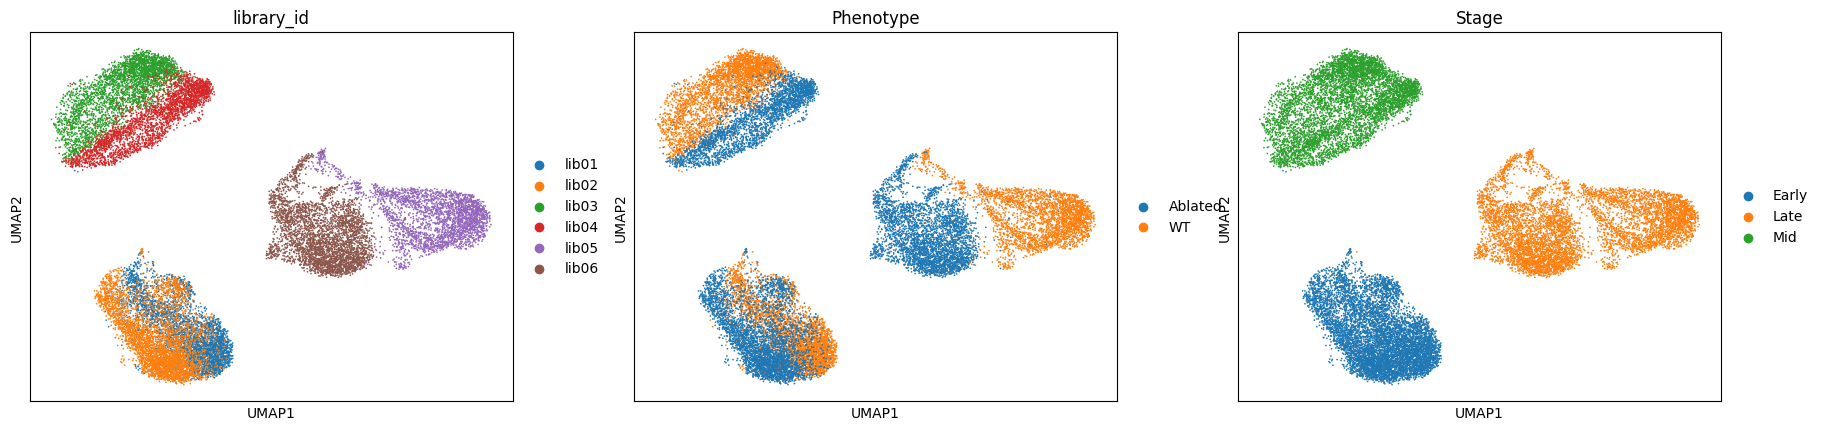

In [8]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['library_id', 'Phenotype', 'Stage'])

## Clustering

In [ ]:
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=['leiden'])

## Marker Gene Identification

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

## Save Processed Data

In [ ]:
adata.write("../scParhyale_data/processed/scParhyale_adata.h5ad")